<a href="https://colab.research.google.com/github/PhD-Gabriel-Caballero/ESA-summer-school-2023-Croatia/blob/main/S2_based%20LAI%20retrieval%20using%20parametric%20indices%20in%20Google%20Earth%20Engine%20(GEE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S2-based LAI retrieval using parametric indices in Google Earth Engine (GEE)

---



Leaf area index (LAI), one half the total green leaf area per unit horizontal ground surface, is an important structural property of vegetation. Because leaf surfaces are the primary border of energy and mass exchange, important processes such as canopy interception, evapotranspiration, and gross photosynthesis are directly proportional to LAI.
[LAI ScienceDirect](https://www.sciencedirect.com/topics/earth-and-planetary-sciences/leaf-area-index#:~:text=Leaf%20area%20index%20is%20defined,of%20leaf%20area%20per%20hectare.)

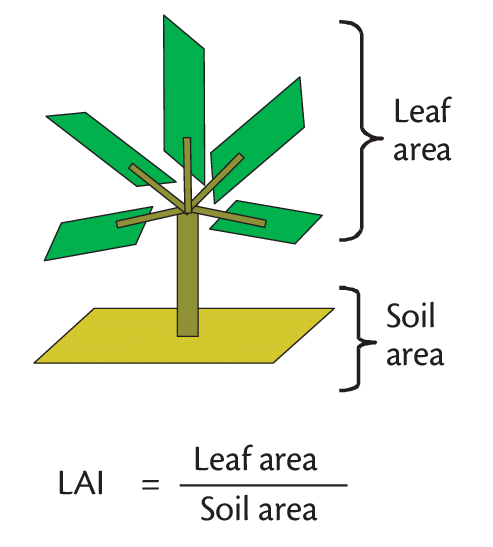

Barrett-Lennard, Edward & Malcolm, C.V. & Bathgate, A. (2003). Saltland Pastures in Australia: A practical guide.

---



In [ ]:
!pip install -U geemap
!pip install earthengine-api
!pip install ipygee

In [6]:
# Import earth engine python api and geemap
import geemap, ee

# Authenticate the earthengine with credentials
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=Bwp_6u3BdYa8mZ6C91zkuSUq7uJOqDwXIb4beiS0OoE&tc=eclkbbvfvxz--CImVYptzocEKG_bsWPr-qPQZByEZMw&cc=DPCRvesJEm5DHXX_U8_imhp4rHJxOJWSyDEEKnjA5VE

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AZEOvhXYr02p4i4U0F_otoI1Y6vhLID8gkrlZe-kphZqynhcnOz6b5JvGKM

Successfully saved authorization token.


In [7]:
# get our Nepal boundary
# I have taken level 0 data for country data from FAO datasets
aoi = ee.FeatureCollection("FAO/GAUL/2015/level0") \
   .filter(ee.Filter.eq('ADM0_NAME','Nepal')).geometry() # adjust indentation here, May get error

In [8]:
def getEVI(image):
    # Compute the EVI using an expression.
    EVI = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': image.select('B8').divide(10000),
            'RED': image.select('B4').divide(10000),
            'BLUE': image.select('B2').divide(10000)
        }).rename("EVI")

    image = image.addBands(EVI)

    return(image)

In [9]:
def addDate(image):
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('YYYYMMdd'))
    return image.addBands(ee.Image(img_date).rename('date').toInt())

In [10]:
# filter sentinel 2 images and apply the EVI formula, finally we obtain
# single image with median operation

Sentinel_data = ee.ImageCollection('COPERNICUS/S2') \
    .filterDate("2022-03-01","2022-03-31").filterBounds(aoi) \
    .map(getEVI)

In [11]:
def getLAI(image):
    LAI = image.expression(
        '(3.618*EVI - 0.118)', {
            'EVI': image.select('EVI')
        }).rename("LAI")
    image = image.addBands(LAI)

    return(image)

In [12]:
Lai_image = Sentinel_data.map(getLAI).map(addDate).median().clip(aoi)

In [13]:
# set some thresholds
#  A nice EVI palette
palett = [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
    '74A901', '66A000', '529400', '3E8601', '207401', '056201',
    '004C00', '023B01', '012E01', '011D01', '011301']

pall = {"min":0.5, "max":3.5, 'palette':palett}
map1 = geemap.Map()
map1.centerObject(aoi, 8)
map1.addLayer(Lai_image.select('LAI'), pall, "LAI")

map1.addLayerControl()
map1

Map(center=[28.268224502649357, 83.97637443188768], controls=(WidgetControl(options=['position', 'transparent_…